In [26]:

!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-xcvkq3_c
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-xcvkq3_c
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 39515ff0fcdae55bbbf546d90193dbe54b201556
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Variance: [  4.4886985   8.7731495   8.861957    7.2635994  12.413831   27.349482
  34.359993   47.612923   40.775578   45.3708     58.5838     51.764183
  64.69304    74.14104    88.952354  106.356544  122.979324  120.21328
 122.78839   138.21689   149.78276   154.52446   168.76306   181.19458
 192.70712   200.2549    205.16985   253.62183   273.1882    308.65817  ]


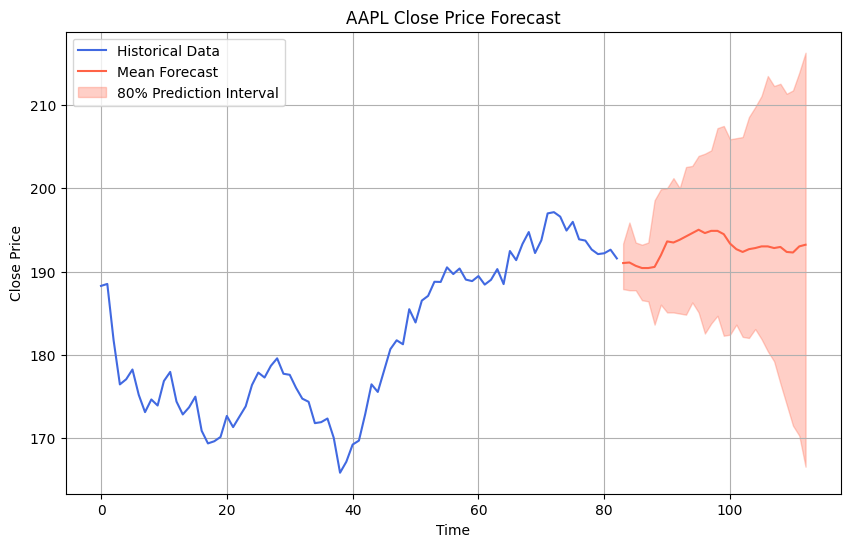

In [27]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

#Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda", # cpu for CPU
    torch_dtype=torch.bfloat16,
)

#Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2023-09-01", end="2023-12-31", progress=False)

#Colonna 'Close' come serie temporale
df = data.reset_index()
close_prices = df["Close"].values.reshape(-1)

#Forecasting
forecast = pipeline.predict(
    context=torch.tensor(close_prices), prediction_length=30
)

#Visualizzazione
forecast_index = range(len(close_prices), len(close_prices) + 30)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(forecast[0].numpy(), axis=0)
variance_forecast = np.var(forecast[0].numpy(), axis=0)

print(f'Variance: {variance_forecast}')

plt.figure(figsize=(10, 6))
plt.plot(close_prices, color="royalblue", label="Historical Data")
plt.plot(forecast_index, mean_forecast, color="tomato", label="Mean Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [28]:
import pandas as pd
import yfinance as yf
import torch
from chronos import BaseChronosPipeline
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Modello CHRONOS
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map=DEVICE,
    torch_dtype=torch.bfloat16,
)

# Dati da Yahoo Finance
symbol = "AAPL"  # Sostituisci con il simbolo dell'azione desiderata
data = yf.download(symbol, start="2020-01-01", end="2023-12-31", progress=False)

# Usa tutte le colonne utili
df = data.reset_index()
covariates = df[["Open", "High", "Low", "Volume", "Close"]].values  # Dati reali
close_prices = df["Close"].values  # Prezzo reale di chiusura

# Finestra mobile per generare il dataset
def generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50):
    X = []
    Y = []
    for t in range(len(covariates) - window_size):
        # Finestra di covariate
        window = covariates[t:t+window_size]

        # Previsione con Chronos per ciascuna covariata
        means = []
        for i in range(window.shape[1]):  # Itera sulle variabili
            context = torch.tensor(window[:, i])  # Serie univariata
            forecast = pipeline.predict(context=context, prediction_length=1)  # Predice il giorno successivo
            mean_forecast = np.mean(forecast[0].numpy())  # Media della distribuzione
            means.append(mean_forecast)

        # Input: Medie delle covariate
        X.append(means)

        # Ground truth: Prezzo di chiusura reale del giorno successivo
        Y.append(close_prices[t+window_size])

    return np.array(X), np.array(Y)

# Genera il dataset
X, Y = generate_dataset_with_chronos(covariates, close_prices, pipeline, window_size=50)

# Stampa dimensioni dataset per verifica
print(f"Dataset X shape: {X.shape}")
print(f"Dataset Y shape: {Y.shape}")

Dataset X shape: (956, 5)
Dataset Y shape: (956, 1)


In [29]:
from sklearn.model_selection import train_test_split
import torch

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Normalizza covariate
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

# Normalizza variabile risposta
scaler_y = StandardScaler()
Y = scaler_y.fit_transform(Y)

# Dividi i dati in training e validation
X_train_split, X_val_split, Y_train_split, Y_val_split = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

# Converti in tensori PyTorch
X_train_split = torch.tensor(X_train_split, dtype=torch.float32)
X_val_split = torch.tensor(X_val_split, dtype=torch.float32)
Y_train_split = torch.tensor(Y_train_split, dtype=torch.float32)
Y_val_split = torch.tensor(Y_val_split, dtype=torch.float32)

# Stampa le dimensioni per conferma
print(f"X_train shape: {X_train_split.shape}, Y_train shape: {Y_train_split.shape}")
print(f"X_val shape: {X_val_split.shape}, Y_val shape: {Y_val_split.shape}")

X_train shape: torch.Size([764, 5]), Y_train shape: torch.Size([764, 1])
X_val shape: torch.Size([192, 5]), Y_val shape: torch.Size([192, 1])


In [30]:
import torch.nn as nn

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

class PricePredictionNN(nn.Module):
        def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
            super(PricePredictionNN, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size_1)
            self.relu1 = nn.ReLU()
            self.dropout1 = nn.Dropout(0.1)
            self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
            self.relu2 = nn.ReLU()
            self.dropout2 = nn.Dropout(0.1)
            self.fc3 = nn.Linear(hidden_size_2, output_size)

        def forward(self, x):
            x = self.dropout1(self.relu1(self.fc1(x)))
            x = self.dropout2(self.relu2(self.fc2(x)))
            x = self.fc3(x)
            return x

In [31]:
LR = 0.001 # Initial learning rate
WEIGHT_DECAY = 4e-5 # Regularization
STEP_SIZE = [150, 300, 600] # Number of epochs before decreasing LR
GAMMA = 0.1 # Multiplicative factor for learning rate step-down

Epoch 0/1000 (LR=0.001), Training Loss: 0.2716, Validation Loss: 0.0355
Epoch 20/1000 (LR=0.001), Training Loss: 0.0082, Validation Loss: 0.0124
Epoch 40/1000 (LR=0.001), Training Loss: 0.0077, Validation Loss: 0.0110
Epoch 60/1000 (LR=0.001), Training Loss: 0.0079, Validation Loss: 0.0117
Epoch 80/1000 (LR=0.001), Training Loss: 0.0073, Validation Loss: 0.0116
Epoch 100/1000 (LR=0.001), Training Loss: 0.0077, Validation Loss: 0.0107
Epoch 120/1000 (LR=0.001), Training Loss: 0.0079, Validation Loss: 0.0114
Epoch 140/1000 (LR=0.001), Training Loss: 0.0076, Validation Loss: 0.0119
Epoch 160/1000 (LR=0.0001), Training Loss: 0.0069, Validation Loss: 0.0107
Epoch 180/1000 (LR=0.0001), Training Loss: 0.0069, Validation Loss: 0.0106
Early stopping at epoch 187


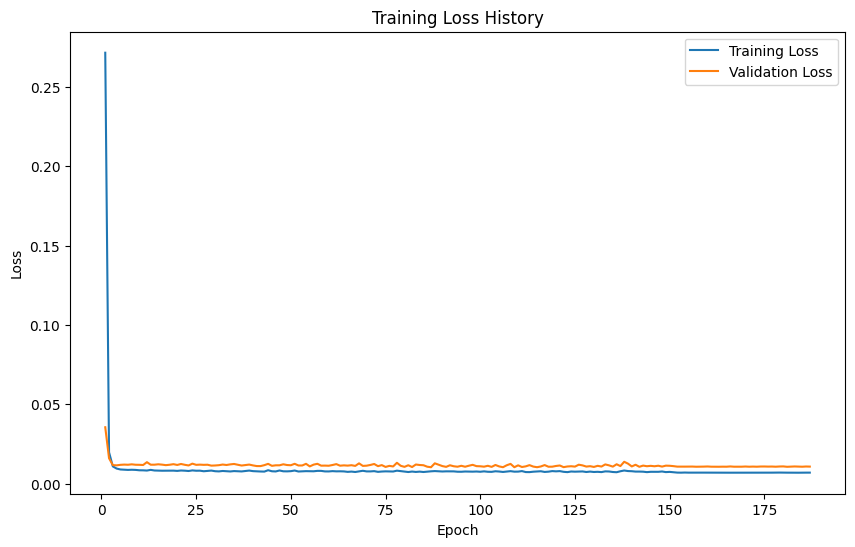

In [32]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, TensorDataset

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Definizione iperparametri
LR = 0.001  # Learning rate iniziale
WEIGHT_DECAY = 4e-5  # Regularization (aiuta a ridurre overfitting)
STEP_SIZE = [150, 300, 600]  # Epoche in cui ridurre il learning rate
GAMMA = 0.1  # Fattore di riduzione del LR

# Creazione del modello
input_size = X.shape[1]  # Numero di feature
hidden_size_1 = 128  # Numero di unità nascoste
hidden_size_2 = 64  # Numero di unità nascoste
output_size = 1  # Prezzo di chiusura predetto
model = PricePredictionNN(input_size, hidden_size_1, hidden_size_2, output_size)

# Ottimizzatore e funzione di perdita
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, eps=1e-4)
criterion = nn.MSELoss()  # Mean Squared Error
scheduler = MultiStepLR(optimizer, milestones=STEP_SIZE, gamma=GAMMA)

# Creazione del DataLoader per il training
batch_size = 32  # Numero di campioni per batch
train_dataset = TensorDataset(X_train_split, Y_train_split)
val_dataset = TensorDataset(X_val_split, Y_val_split)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Early stopping
best_loss = float("inf")
patience = 100  # Numero massimo di epoche senza miglioramenti
patience_counter = 0

loss_history = []
loss_history_val = []

# Inizializzazione del training
num_epochs = 1000
model.train()

for epoch in range(num_epochs):
    train_loss = 0.0

    # Training loop
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_Y)

        # Backpropagation e aggiornamento
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)  # Media della loss per batch
    loss_history.append(train_loss)

    # Validation loop
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_predictions_list = []

    with torch.no_grad():
        for batch_X, batch_Y in val_loader:
            val_predictions = model(batch_X)
            val_predictions_list.append(val_predictions.numpy())  # Salviamo le previsioni

            loss = criterion(val_predictions, batch_Y)
            val_loss += loss.item()

    # Convertiamo l'elenco in array numpy
    val_predictions = np.concatenate(val_predictions_list, axis=0)

    # Riportiamo i dati alla scala originale
    val_predictions_original = scaler_y.inverse_transform(val_predictions)

    val_loss /= len(val_loader)  # Media della loss per batch
    loss_history_val.append(val_loss)

    # Step del learning rate scheduler
    scheduler.step()

    current_lr = optimizer.param_groups[0]['lr']

    # Stampa ogni 20 epoche
    if epoch % 20 == 0:
        print(f"Epoch {epoch}/{num_epochs} (LR={current_lr}), Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # Salva il miglior modello
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Plot della loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history) + 1), loss_history, label="Training Loss")
plt.plot(range(1, len(loss_history_val) + 1), loss_history_val, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()

(21, 5)
(1006, 1)


<ipython-input-40-e3c5ce40f715>:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


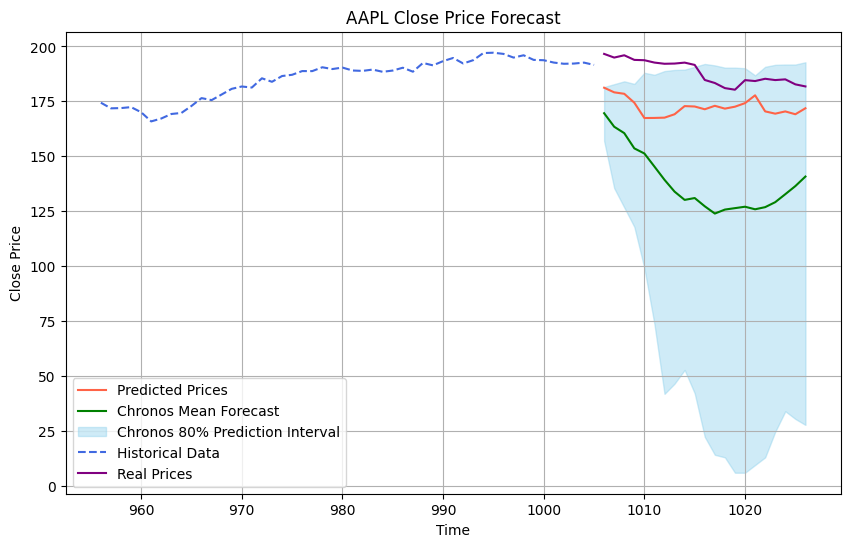

In [40]:
# Test on new data (from 2024), plotting the true value,
# the value predicted by our NN and the value (+confidence interval) predicted by Chronos, to compare them.
# Ensure that the vectors plotted are of the correct dimensions

seed = 343126
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# Nuovi dati
new_data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
#new_covariates = new_data[["Open", "High", "Low", "Volume", "Close"]].values
#new_close_prices = new_data["Close"].values
# Definiamo il numero di giorni della finestra temporale
window_size = 10  # Stesso valore usato nel training

# Estendiamo i dati di test includendo gli ultimi `window_size` giorni del training
extended_new_data = pd.concat([df.iloc[-window_size:], new_data])  # Unisce ultimi giorni training + test

# Estraiamo le feature
new_covariates = extended_new_data[["Open", "High", "Low", "Volume", "Close"]].values
new_close_prices = extended_new_data["Close"].values

# Genera dati di test con la finestra mobile
X_test, Y_test = generate_dataset_with_chronos(new_covariates, new_close_prices, pipeline)
X_test = scaler_x.transform(X_test)

print(X_test.shape)

# Converti in tensore
X_test = torch.tensor(X_test, dtype=torch.float32)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()
with torch.no_grad():
    test_predictions = model(X_test)

test_predictions = scaler_y.inverse_transform(test_predictions)

print(close_prices.shape)

# Indici temporali per i dati storici e di test
historical_index = np.arange(len(close_prices))  # Dati storici
test_index = np.arange(len(close_prices), len(close_prices) + len(test_predictions))

# Riduci le dimensioni del contesto e della lunghezza della previsione per Chronos
chronos_context = torch.tensor(close_prices[-100:])  # Usa gli ultimi 500 punti dati come contesto
chronos_prediction_length = len(test_predictions)

chronos_forecast = pipeline.predict(context=chronos_context, prediction_length=chronos_prediction_length)
low, median, high = np.quantile(chronos_forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast = np.mean(chronos_forecast[0].numpy(), axis=0)

# Assicurati che i vettori abbiano le dimensioni corrette
mean_forecast = mean_forecast[:len(test_predictions)]
low = low[:len(test_predictions)]
high = high[:len(test_predictions)]


# Grafico
plt.figure(figsize=(10, 6))

plt.plot(test_index, test_predictions, color="tomato", label="Predicted Prices")  # Nostre previsioni
plt.plot(test_index, mean_forecast, color="green", label="Chronos Mean Forecast") # Chronos
plt.fill_between(test_index, low, high, color="skyblue", alpha=0.4, label="Chronos 80% Prediction Interval")  # Chronos confidence

# Plot the history, only last 50 timesteps
plt.plot(historical_index[-50:], close_prices[-50:], color="royalblue", label="Historical Data", linestyle='--')  # Storico


# Plot the "real" line
plt.plot(test_index, new_close_prices[:len(test_predictions)], color="purple", label="Real Prices") #Taglio per allineare i vettori

plt.title(f"{symbol} Close Price Forecast")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calcola MAE, RMSE e MAPE per il tuo modello
mae_nn = mean_absolute_error(new_close_prices[:len(test_predictions)], test_predictions)
rmse_nn = mean_squared_error(new_close_prices[:len(test_predictions)], test_predictions)
mape_nn = np.mean(np.abs((new_close_prices[:len(test_predictions)] - test_predictions) / new_close_prices[:len(test_predictions)])) * 100

# Calcola MAE, RMSE e MAPE per Chronos
mae_chronos = mean_absolute_error(new_close_prices[:len(mean_forecast)], mean_forecast)
rmse_chronos = mean_squared_error(new_close_prices[:len(mean_forecast)], mean_forecast)
mape_chronos = np.mean(np.abs((new_close_prices[:len(mean_forecast)] - mean_forecast) / new_close_prices[:len(mean_forecast)])) * 100

# Stampa i risultati
print("=== MODEL PERFORMANCE COMPARISON ===")
print(f"Neural Network -> MAE: {mae_nn:.4f}, RMSE: {rmse_nn:.4f}, MAPE: {mape_nn:.2f}%")
print(f"Chronos        -> MAE: {mae_chronos:.4f}, RMSE: {rmse_chronos:.4f}, MAPE: {mape_chronos:.2f}%")

=== MODEL PERFORMANCE COMPARISON ===
Neural Network -> MAE: 15.8249, RMSE: 282.3617, MAPE: 8.35%
Chronos        -> MAE: 50.2223, RMSE: 2622.6401, MAPE: 26.61%
